In [34]:
import os
import json
from pathlib import Path
import pandas as pd
import dedupe
from dotenv import find_dotenv, load_dotenv
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
import pickle
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
load_dotenv(find_dotenv())

True

In [5]:
def jaro_similarity(s1, s2):
    # First, store the length of the strings
    # because they will be re-used several times.
    len_s1, len_s2 = len(s1), len(s2)

    # The upper bound of the distance for being a matched character.
    match_bound = max(len_s1, len_s2) // 2 - 1

    # Initialize the counts for matches and transpositions.
    matches = 0  # no.of matched characters in s1 and s2
    transpositions = 0  # no. of transpositions between s1 and s2
    flagged_1 = []  # positions in s1 which are matches to some character in s2
    flagged_2 = []  # positions in s2 which are matches to some character in s1

    # Iterate through sequences, check for matches and compute transpositions.
    for i in range(len_s1):  # Iterate through each character.
        upperbound = min(i + match_bound, len_s2 - 1)
        lowerbound = max(0, i - match_bound)
        for j in range(lowerbound, upperbound + 1):
            if s1[i] == s2[j] and j not in flagged_2:
                matches += 1
                flagged_1.append(i)
                flagged_2.append(j)
                break
    flagged_2.sort()
    for i, j in zip(flagged_1, flagged_2):
        if s1[i] != s2[j]:
            transpositions += 1

    if matches == 0:
        return 0
    else:
        return (
            1
            / 3
            * (
                matches / len_s1
                + matches / len_s2
                + (matches - transpositions // 2) / matches
            )
        )
def jaro_winkler_similarity(s1, s2, p=0.1, max_l=4):
    # To ensure that the output of the Jaro-Winkler's similarity
    # falls between [0,1], the product of l * p needs to be
    # also fall between [0,1].
    if not 0 <= max_l * p <= 1:
        warnings.warn(
            str(
                "The product  `max_l * p` might not fall between [0,1]."
                "Jaro-Winkler similarity might not be between 0 and 1."
            )
        )

    # Compute the Jaro similarity
    jaro_sim = jaro_similarity(s1, s2)

    # Initialize the upper bound for the no. of prefixes.
    # if user did not pre-define the upperbound,
    # use shorter length between s1 and s2

    # Compute the prefix matches.
    l = 0
    # zip() will automatically loop until the end of shorter string.
    for s1_i, s2_i in zip(s1, s2):
        if s1_i == s2_i:
            l += 1
        else:
            break
        if l == max_l:
            break
    # Return the similarity value as described in docstring.
    return jaro_sim + (l * p * (1 - jaro_sim))

def city_similarity(companyA, companyB):
    cityA = companyA['address.city'][:6] if pd.isnull(companyA['address.city']) is not True else companyA['address.city']
    cityB = companyB['address.city'][:6] if pd.isnull(companyB['address.city']) is not True else companyB['address.city']
    if cityA.lower() == cityB.lower():
        return 1
    else:
        return 0  
def street_similarity(companyA, companyB):
    streetA = companyA['address.street'][:6] if pd.isnull(companyA['address.street']) is not True else companyA['address.street']
    streetB = companyB['address.street'][:6] if pd.isnull(companyB['address.street']) is not True else companyB['address.street']
    if str(streetA).lower() == str(streetB).lower():
        return 1
    else:
        return 0  
def phone_similarity(companyA, companyB):
    phoneA = companyA['phone_number'][:7] if pd.isnull(companyA['phone_number']) is not True else companyA['phone_number']
    phoneB = companyB['phone_number'][:7] if pd.isnull(companyB['phone_number']) is not True else companyB['phone_number']
    if phoneA == phoneB:
        return 1
    else:
        return 0  
    
def name_similarity(companyA, companyB):
    nameA = companyA['name']
    nameB = companyB['name']
    return jaro_winkler_similarity(nameA, nameB)

def postcode_similarity(companyA, companyB):
    codeA = companyA['address.postal_code']
    codeB = companyB['address.postal_code']
    if codeA == codeB:
        return 1
    else:
        return 0
    
def legalform_similarity(companyA, companyB):
    legalA = companyA['legal_form']
    legalB = companyB['legal_form']
    if str(legalA).lower() == str(legalB).lower():
        return 1
    else:
        return 0
    
def pairwise_similarity(entity_ref: dict, entity_eval: dict) -> []:
    sim = dict()
    sim['name'] = name_similarity(entity_ref, entity_eval)
    sim['legal_form'] = legalform_similarity(entity_ref, entity_eval)
    sim['address.postal_code'] = postcode_similarity(entity_ref, entity_eval)
    sim['phone_number'] = phone_similarity(entity_ref, entity_eval)
    sim['address.street'] = street_similarity(entity_ref, entity_eval)
    return sim

In [6]:
import re

rgxBV  = re.compile(r"( B\.?V\.?( | ?&|,|-|$))|((B|b)(esloten|ESLOTEN)(V|v)((ennootschap|ENNOOTSCHAP) (MET|met) (beperkte|BEPERKTE) (A|a)(ansprakelijkheid|ANSPRAKELIJKHEID))?)")
rgxEV  = re.compile(r"( |,|\.|^)(E|e)\.?(V|v)( |,|\.|$)|(|,|\.|^)(E|e)(INGETRAGENER|ingetragener) (V|v)(EREIN|erein)")
rgxVAG = re.compile(r"( |,|\.|^)(V|v)\.?(A|a)\.?(G)( |,|\.|$)")
rgxEG  = re.compile(r"(G|g)(ENOSSENSCHAFT|genossenschaft)|( |,|\.|^)(E|e)(INGETRAGENE|ingetragene) (G|g)(EN|en)\.?(OSSENSCHAFT|ossenschaft)?|( |,|\.|^)(E|e)\.(G|g)(|,|\.|$)|eG( |,|\.|$)")
rgxGBR = re.compile(r"(G|g)?(E|e)?(S|s)?\.?(ELL|ell)?\.?(SCH|sch)?\.?(AFT|aft)?(B|b)(Ü|ü|UE|ue)(RGERLICHEN|rgerlichen) (R|r)(ECHTS|echts)|(|,|\.|^)(Gbr|GbR|GBR)( |,|$)|(|,|\.)(Inh\.?(aber)?(in)?|INH\.?(ABER)?(IN)?)")
rgxUCO = re.compile(r"(&|\+| UND | und | (U|u)(\.| )) ?(C|c)(O|o|IE|Ie|ie)( |,|-|\.|$|\)?)")
rgxAG  = re.compile(r"(( |-)A(G|g)( | ?&|,|-|$))|A(C|c|K|k)(TIEN|tien)-?(GES|ges)\.?(ELLSCHAFT|ellschaft|ELLSCH|ellsch)?\.?")
rgxSE  = re.compile(r"(( |-)SE( | ?&|,|-|$))|S(OCIETAS|ocietas) ?(E|e)(UROP|urop)")
rgxUG  = re.compile(r"((( |-)U((G|G-)|g)( |,|$))|(U(NTERN|ntern)\.?-?(EHMER|ehmer)? ?(GES|ges)\.?(ELLSCHAFT|ellschaft|ELLSCH|ellsch)?\.?))(\(?haftungsbeschr\.?(ä|ae)?(nkt)?\)?)?")
rgxLTD = re.compile(r"(U(K|k))?( |,|\.|^)(LTD|Ltd)(-| |,|\.|$)|UK (Limited|LIMITED)")
rgxGMBH = re.compile(r"(G|g)?(E|e)?(S|s)?\.?(ELL|ell)?\.?(SCH|sch)?\.?(AFT|aft)? ?(M|m)\.?(IT|it)? ?(B|b)(ESCHR|eschr)?\.?(Ä|ä)?(AE?|ae?)?(NKTER|nkter)? ?(H|h)( |,|\.|$|AFTUNG|aftung)")
rgxKG = re.compile(r"(( |-)(K|k)\.?(G|g)( |&|,|-|\.|$|aA))|K(O|o)(M|m)(M|m)(A|a)(N|n)(D|d)(I|i)(T|t)\.?(G|g)?\.?(E|e)?(S|s)?\.?(E|e)?(L|l)?(L|l)?\.?(S|s)?(C|c)?(H|h)?\.?(A|a)?(F|f)?(T|t)?")
rgxOHG = re.compile(r"( O\.?H\.?G\.?)( |,|$)|(O|o)(FF|ff)\.? ?(ENE|ene)?\.? ?(H|h)(ANDELS|andels)( |-)? ?(G|g)\.?(E|e)(S|s)\.?(E|e)?(L|l)?(L|l)?\.?(S|s)?(C|c)?(H|h)?\.?(A|a)?(F|f)?(T|t)?")
rgxKGAA = re.compile(r"(( |-)(K|k)(G|g)(a|A)A)|K(O|o)(M|m)(M|m)(A|a)(N|n)(D|d)(I|i)(T|t).*((A|a)uf A(ktien|KTIEN))")

def legalFormDetector(s):
    """ Detects a company´s legal form if the legal form is part of the string s.
    Detection is done by applying various regular expressions to match different
    spellings of legal forms. Considered legal forms are mainly the ones most releveant for the
    DACH region.

    Returns: detected legal form, normalized company name string (replacing legal form by canonical one)
        
    """
    form, name = legalFormDetectorRaw(s)
    return form, re.sub(' +',' ', name).strip()

def legalFormDetectorRaw(s):
    if (rgxAG.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "AG & Co. KG", rgxAG.sub(" AG ", rgxUCO.sub(" & Co. ", rgxKG.sub("KG", s)))
    if (rgxAG.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "AG & Co. KGaA", rgxAG.sub(" AG ", rgxUCO.sub(" & Co. ", rgxKGAA.sub("KgaA", s)))
    if (rgxAG.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "AG & Co. OHG", rgxAG.sub(" AG ", rgxUCO.sub(" & Co. ", rgxOHG.sub("OHG", s)))
    if (rgxBV.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "BV & Co. KG", rgxBV.sub(" BV ", rgxUCO.sub(" & Co. ",rgxKG.sub("KG", s)))
    if (rgxBV.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "BV & Co. KGaA", rgxBV.sub(" BV ", rgxUCO.sub(" & Co. ",rgxKGAA.sub("KgaA", s)))
    if (rgxBV.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "BV & Co. OHG", rgxBV.sub(" BV ", rgxUCO.sub(" & Co. ",rgxOHG.sub("OHG", s)))
    if (rgxGMBH.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "GmbH & Co. KG", rgxGMBH.sub(" GmbH ", rgxUCO.sub(" & Co. ",rgxKG.sub("KG", s)))
    if (rgxGMBH.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "GmbH & Co. KGaA", rgxGMBH.sub(" GmbH ", rgxUCO.sub("&  Co. ",rgxKGAA.sub("KgaA", s)))
    if (rgxGMBH.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "GmbH & Co. OHG", rgxGMBH.sub(" GmbH ", rgxUCO.sub(" & Co. ",rgxOHG.sub("OHG", s)))
    if (rgxLTD.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "Ltd. & Co. KG", rgxLTD.sub(" Ltd. ", rgxUCO.sub(" & Co. ",rgxKG.sub("KG", s)))
    if (rgxLTD.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "Ltd. & Co. KGaA", rgxLTD.sub(" LTD ", rgxUCO.sub(" & Co. ",rgxKGAA.sub("KgaA", s)))
    if (rgxLTD.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "Ltd. & Co. OHG", rgxLTD.sub(" LTD ", rgxUCO.sub(" & Co. ",rgxOHG.sub("OHG", s)))
    if (rgxSE.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "SE & Co. KG", rgxSE.sub(" SE ", rgxUCO.sub(" & Co. ",rgxKG.sub("KG", s)))
    if (rgxSE.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "SE & Co. KGaA", rgxSE.sub(" SE ", rgxUCO.sub(" & Co. ",rgxKGAA.sub("KgaA", s)))
    if (rgxSE.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "SE & Co. OHG", rgxSE.sub(" SE ", rgxUCO.sub(" & Co. ",rgxOHG.sub("OHG", s)))
    if (rgxUG.search(s) and rgxUCO.search(s) and rgxKG.search(s)):
        return "UG & Co. KG", rgxUG.sub(" UG ", rgxUCO.sub(" & Co. ",rgxKG.sub("KG", s)))
    if (rgxUG.search(s) and rgxUCO.search(s) and rgxKGAA.search(s)):
        return "UG & Co. KGaA",  rgxUG.sub(" UG ", rgxUCO.sub(" & Co. ",rgxKGAA.sub("KgaA", s)))
    if (rgxUG.search(s) and rgxUCO.search(s) and rgxOHG.search(s)):
        return "UG & Co. OHG", rgxUG.sub(" UG ", rgxUCO.sub(" & Co. ",rgxOHG.sub("OHG", s)))
    if (rgxGMBH.search(s)):      
        return "GmbH", rgxGMBH.sub(" GmbH ", s)
    if (rgxLTD.search(s)):
        return "Ltd.", rgxLTD.sub(" Ltd. ", s)
    if (rgxBV.search(s)):
        return "BV", rgxBV.sub(" BV ", s)
    if (rgxUG.search(s)):
        return "UG", rgxUG.sub(" UG ", s)
    if (rgxEG.search(s)):
        return "e.G.", rgxEG.sub(" e.G. ", s)
    if (rgxKGAA.search(s)):
        return "KGaA", rgxKGAA.sub(" KGaA ", s)
    if (rgxKG.search(s)):
        return "KG", rgxKG.sub(" KG ", s)
    if (rgxOHG.search(s)):
        return "OHG", rgxOHG.sub(" OHG ", s)
    if (rgxAG.search(s)):
        return "AG", rgxAG.sub(" AG ", s)
    if (rgxSE.search(s)):
        return "SE", rgxSE.sub(" SE ", s)
    if (rgxEV.search(s)):
        return "e.V.", rgxEV.sub(" e.V. ", s)
    if (rgxGBR.search(s)):
        return "GbR", rgxGBR.sub(" GbR ", s)
    if (rgxVAG.search(s)):
        return "V.a.G.", rgxVAG.sub(" V.a.G. ", s)

    return "NA", s

In [7]:
def sanitize(s):
    if s is None:
        return s

    s = str(s)
    processed = re.sub('http','',s).lower()
    processed = re.sub('https','',processed).lower()
    processed = re.sub('www','',processed).lower()
    processed = re.sub('[\!\:\"#\.%&@\(\,\-\/)+]','',processed).lower()

    blacklist = stopwords.words('german')
    for word in blacklist:
        processed = processed.replace(" " + word + " ", " ")
    return processed.strip()

def sanitize_entity(entity):
    lfd = legalFormDetector(entity['name'])
    entity['name'] = lfd[1]
    entity['legal_form'] = lfd[0] if lfd[0] !='NA' else entity['legal_form']
    entity['name'] = sanitize(entity['name'])
    entity['address.street'] = sanitize(entity['address.street'])
    return entity
    

In [8]:
DEDUPE_2_ERS_DATAFIELD_MAPPING = {'abs_name':'name', 'abs_legal_form':'legal_form',
                                'abs_register_number':'register_number', 'abs_hq_email':'email', 'abs_website':'website',
                                'abs_hq_phone':'phone_number', 'abs_taxid':'vat_id',
                                'abs_hq_street':'address.street', 'abs_hq_zip_code':'address.postal_code',
                                'abs_hq_city':'address.city', 'abs_hq_country':'address.country',
                                'record_id':'record_id'}

In [10]:
trainset_filepath = str('ERS_data/sanitized-trainingdata.json')
with open(trainset_filepath) as file:
    trainset = json.load(file)

In [11]:
test_filepath = str('ERS_data/sanitized-testdata.json')
with open(test_filepath) as file:
    testset = json.load(file)

In [8]:
trainset

{'match': [[{'name': 'hufer ingenieur gmbh',
    'legal_form': 'GmbH',
    'register_number': '10538',
    'email': None,
    'website': None,
    'phone_number': '02151/974933',
    'vat_id': None,
    'address.street': 'klever str 264',
    'address.postal_code': '47839',
    'address.city': 'Krefeld',
    'address.country': 'DE',
    'record_id': '510bcf90-d3d9-11e4-b3ef-53b449010d08'},
   {'name': 'hufer ingenieur gmbh',
    'legal_form': 'GmbH',
    'register_number': None,
    'email': None,
    'website': 'http://www.hufer-ib.de/',
    'phone_number': '0049 02151 974933',
    'vat_id': None,
    'address.street': 'klever str 264',
    'address.postal_code': '47839',
    'address.city': 'Krefeld',
    'address.country': 'DE',
    'record_id': '510bcf90-d3d9-11e4-b3ef-53b449010d08'}],
  [{'name': 'güthlein e k',
    'legal_form': 'Einzelfirma',
    'register_number': '4768',
    'email': None,
    'website': None,
    'phone_number': '09133/602690',
    'vat_id': None,
    'addres

In [12]:
legalFormDetector('dcm aviation gmbh')

('GmbH', 'dcm aviation GmbH')

## if not loading sanitized training set, do the following sanitizing steps

In [8]:
for [a, b] in trainset['match']:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        b[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = b.pop(field)
for [a, b] in trainset['distinct']:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        b[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = b.pop(field)

for match in trainset['match']:
    match[0] = sanitize_entity(match[0])
    match[1] = sanitize_entity(match[1])
for distinct in trainset['distinct']:
    distinct[0] = sanitize_entity(distinct[0])
    distinct[1] = sanitize_entity(distinct[1])


In [10]:
import json
with open(str(Path(os.getenv('DATA_PATH')) / 'ers_data' / 'sanitized-trainingdata.json'), 'w') as outfile:
    json.dump(trainset, outfile)

In [9]:
for [a, b] in testset['match']:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        b[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = b.pop(field)
for [a, b] in testset['distinct']:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        b[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = b.pop(field)

for match in testset['match']:
    match[0] = sanitize_entity(match[0])
    match[1] = sanitize_entity(match[1])
for distinct in testset['distinct']:
    distinct[0] = sanitize_entity(distinct[0])
    distinct[1] = sanitize_entity(distinct[1])

In [11]:
with open(str(Path(os.getenv('DATA_PATH')) / 'ers_data' / 'sanitized-testdata.json'), 'w') as outfile:
    json.dump(testset, outfile)

In [53]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# prepare the data by calculating pairwise similarity

In [13]:
match_train = trainset['match']
distinct_train = trainset['distinct']

In [14]:
train_set = list()
for pair in match_train:
    similarities = pairwise_similarity(pair[0], pair[1])
    similarities.update({ 'is_match': 1 })
    train_set.append(similarities)
for pair in distinct_train:
    similarities = pairwise_similarity(pair[0], pair[1])
    similarities.update({'is_match': 0 })
    train_set.append(similarities)
train_set = pd.DataFrame.from_dict(train_set)

In [15]:
train_set.head(5)

address.postal_code  address.street  is_match  legal_form      name  \
0                    1               1         1           1  1.000000   
1                    1               1         1           0  0.983333   
2                    1               1         1           1  1.000000   
3                    1               1         1           1  0.986025   
4                    1               1         1           1  0.972978   

   phone_number  
0             0  
1             0  
2             0  
3             0  
4             0

In [16]:
match_test = testset['match']
distinct_test = testset['distinct']

In [17]:
test_set = list()
for pair in match_test:
    similarities = pairwise_similarity(pair[0], pair[1])
    similarities.update({ 'is_match': 1 })
    test_set.append(similarities)
    
for pair in distinct_test:
    similarities = pairwise_similarity(pair[0], pair[1])
    similarities.update({'is_match': 0 })
    test_set.append(similarities)

In [18]:
test_set = pd.DataFrame.from_dict(test_set)

In [19]:
len(test_set[test_set['is_match']==1])

41898

In [20]:
len(test_set[test_set['is_match']==0])

41898

## training GradientBoostingClassifier  and test 

In [30]:
gbc_model = GradientBoostingClassifier()
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gbc_model.get_params())

Parameters currently in use:

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5, 8, 12, 16, 20]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42)
# Fit the random search model
gbc_random.fit(train_set[train_set.columns.difference(['is_match'])], train_set['is_match'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  30.0s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  27.1s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  27.5s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  26.8s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  31.9s
[CV] n_estimators=16, min_samples_split=10, min_samples_leaf=2, max_depth=6 
[CV]  n_estimators=16, min_samples_split=10, min_samples_leaf=2, max_depth=6, total=   3.7s
[CV] n_estimators=16, min_samples_split=10, min_samples_leaf=2, max_depth=6 
[CV]  n_estimators=16, min_samples_split=10, min_samples_leaf=2, max_depth=6, total=   4.0s
[CV] n_estimators=16, min_samples_split=10, min_samples_leaf=2, max_de

[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8, total=   8.5s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8, total=   8.6s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8, total=   8.7s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8, total=   8.6s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=8, total=   8.4s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=11 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=11, total=  20.8s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, 

[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_depth=20, total=  15.5s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18, total=  21.1s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18, total=  20.3s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18, total=  22.3s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18, total=  21.0s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_depth=18, total=  21.7s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=2, m

[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_depth=6, total=   3.5s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_depth=6 
[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_depth=6, total=   3.4s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18, total=  42.7s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18, total=  41.5s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18, total=  41.8s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_depth=18, total=  41.6s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max

[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=4, max_depth=14, total=  19.4s
[CV] n_estimators=12, min_samples_split=10, min_samples_leaf=4, max_depth=14 
[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=4, max_depth=14, total=  20.6s
[CV] n_estimators=12, min_samples_split=10, min_samples_leaf=4, max_depth=14 
[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=4, max_depth=14, total=  20.4s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11, total=   5.1s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11, total=   5.2s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_depth=11, total=   5.2s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, ma

[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12, total=   6.7s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12, total=   6.8s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12, total=   6.7s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=1, max_depth=12, total=   6.3s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=18, total= 1.0min
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=18 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_depth=18, total= 1.0min
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_dep

[CV]  n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  26.5s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14 
[CV]  n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  26.8s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14 
[CV]  n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  26.1s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14 
[CV]  n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  23.6s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14 
[CV]  n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  22.9s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_depth=17 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_depth=17, total=  53.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, 

[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_depth=14, total=  59.1s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12, total=  20.7s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12, total=  15.4s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12, total=  15.2s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12, total=  15.8s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_depth=12, total=  16.1s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=4, m

[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_depth=6, total=   2.8s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_depth=6 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_depth=6, total=   2.7s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12, total=  23.7s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12, total=  23.2s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12, total=  23.8s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_depth=12, total=  24.9s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max

[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=4, max_depth=8, total=   3.2s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=4, max_depth=8 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=4, max_depth=8, total=   3.3s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=4, max_depth=8 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=4, max_depth=8, total=   3.2s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12, total=   9.1s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12, total=   8.9s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=12, total=   9.0s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_depth=

[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18, total=  50.9s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18, total=  55.5s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18, total=  55.8s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_depth=18, total=  54.7s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=15 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=15, total=  37.2s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=15 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_depth=15, total=  36.4s
[CV] n_estimators=20, min_samples_split=10, min_samples_lea

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 153.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [5, 8, 12, 16, 20], 'max_depth': [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [36]:
gbc_random.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 16}

In [37]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    
    comparations = predictions - test_labels
    false_positive_list = np.where(comparations == 1)[0]
    false_negative_list = np.where(comparations == -1)[0]
    
    # evaluate predictions
    accuracy = accuracy_score(test_labels, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    precision = precision_score(test_labels, predictions)
    print("Precision: %.2f%%" % (precision * 100.0))
    
    recall = recall_score(test_labels, predictions)
    print("Recall: %.2f%%" % (recall * 100.0))
    
    false_positives = predictions 
    
    return accuracy, precision, recall, false_positive_list, false_negative_list

In [39]:
# using base model without choosing hyperparameters
base_model = GradientBoostingClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_set[train_set.columns.difference(['is_match'])], train_set['is_match'])
base_accuracy = evaluate(base_model, test_set[test_set.columns.difference(['is_match'])], test_set['is_match'])[0]

Model Performance
Accuracy: 93.15%
Precision: 89.98%
Recall: 97.11%


In [40]:
best_random = gbc_random.best_estimator_
random_accuracy = evaluate(best_random, test_set[test_set.columns.difference(['is_match'])], test_set['is_match'])[0]

Model Performance
Accuracy: 94.72%
Precision: 93.62%
Recall: 95.98%


In [41]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.68%.


## save best gbc classifier

In [45]:
import pickle
filename = 'gbc_bestrandom.sav'
pickle.dump(best_random, open(filename, 'wb'))

## importance of features

In [46]:
list(zip(list(train_set.columns.difference(['is_match'])), best_random.feature_importances_))

[('address.postal_code', 0.01088414964482064),
 ('address.street', 0.024501608152558432),
 ('legal_form', 0.006578930235157112),
 ('name', 0.9445236708956427),
 ('phone_number', 0.013511641071821012)]

In [47]:
probs = best_random.predict_proba(test_set[test_set.columns.difference(['is_match'])])[:, 1]
probs

array([0.8998846 , 0.89357381, 0.84396383, ..., 0.10670878, 0.10246321,
       0.09792059])

In [48]:
predictions = best_random.predict(test_set[test_set.columns.difference(['is_match'])])
confusion_matrix(test_set['is_match'], predictions)

array([[39158,  2740],
       [ 1685, 40213]])

In [49]:
precision, recall, thresholds = precision_recall_curve(test_set['is_match'], probs)

In [50]:
thresholds

array([0.09676884, 0.09690691, 0.09690942, ..., 0.90982672, 0.91138362,
       0.91273815])

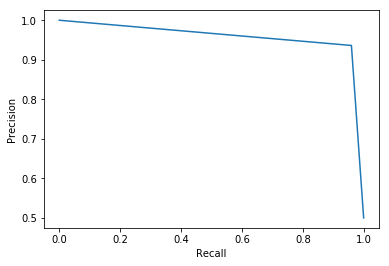

In [51]:
precision, recall, thresholds = precision_recall_curve(test_set['is_match'], predictions)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Confusion matrix, without normalization
[[39158  2740]
 [ 1685 40213]]
Normalized confusion matrix
[[0.93460308 0.06539692]
 [0.04021672 0.95978328]]


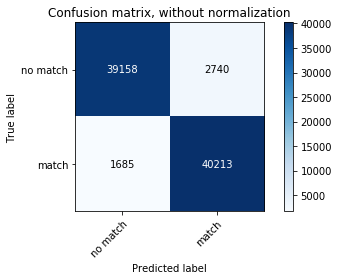

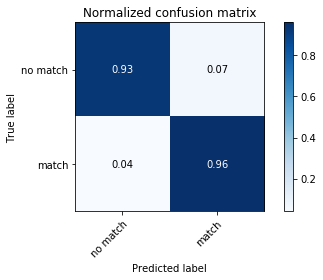

In [54]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_set['is_match'], predictions,classes=np.array(["no match", "match"]), 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_set['is_match'], predictions, classes=np.array(["no match", "match"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Train Random Forest classifier

In [18]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(random_state=47)

In [19]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 47,
 'verbose': 0,
 'warm_start': False}


In [27]:
# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

## random hyperparameter grid
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5, 8, 12, 16, 20]}


In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf_random.fit(train_set[train_set.columns.difference(['is_match'])], train_set['is_match'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False, total=   3.2s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False, total=   2.9s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False, total=   2.6s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False, total=   3.0s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=False, total=   3.1s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=8, min_samples_spli

[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, total=   2.6s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, total=   2.5s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, total=   2.5s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, total=   2.5s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2,

[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   3.7s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   4.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   3.9s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=False, total=   3.7s
[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=8, min_samp

[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   1.5s
[CV] n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   1.6s
[CV] n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   1.5s
[CV] n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   1.5s
[CV] n_estimators=12, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=12, min_samples_sp

[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=   2.1s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=   2.0s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=   2.0s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=   2.0s
[CV] n_estimators=5, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=15, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=10,

[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   0.6s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   0.6s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   0.6s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   0.5s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf

[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.4s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.6s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.7s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   2.4s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=False 
[CV]  n_estimators=8, min_samples_spl

[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   1.3s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   1.2s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   1.3s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=12, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, total=   1.3s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=5, min_sampl

[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True, total=   1.9s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True, total=   2.0s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True, total=   2.4s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=14, bootstrap=True, total=   1.9s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=18, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=2,

[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   0.7s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=5, min_samp

[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True, total=   2.8s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True, total=   2.8s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True, total=   2.7s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=18, bootstrap=True, total=   2.8s
[CV] n_estimators=12, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=12, min_samples_split=5,

[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=   1.6s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=   1.6s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=   1.6s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=   1.5s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True 
[CV]  n_estimators=5, min_samples_split

[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, bootstrap=True, total=   0.7s
[CV] n_estimators=5, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=10, min_sam

[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.9s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   1.0s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   1.0s
[CV] n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.9s
[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=16, min_samples_split=5, 

[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True, total=   1.0s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True, total=   1.0s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True, total=   1.0s
[CV] n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=True, total=   1.0s
[CV] n_estimators=5, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=10, min_samp

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 16.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': [5, 8, 12, 16, 20], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 16,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [32]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    
    comparations = predictions - test_labels
    false_positive_list = np.where(comparations == 1)[0]
    false_negative_list = np.where(comparations == -1)[0]
    
    # evaluate predictions
    accuracy = accuracy_score(test_labels, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    precision = precision_score(test_labels, predictions)
    print("Precision: %.2f%%" % (precision * 100.0))
    
    recall = recall_score(test_labels, predictions)
    print("Recall: %.2f%%" % (recall * 100.0))
    
    false_positives = predictions 
    
    return accuracy, precision, recall, false_positive_list, false_negative_list

In [41]:
# using base model without choosing hyperparameters
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_set[train_set.columns.difference(['is_match'])], train_set['is_match'])
base_accuracy = evaluate(base_model, test_set[test_set.columns.difference(['is_match'])], test_set['is_match'])[0]

Model Performance
Accuracy: 94.75%
Precision: 93.84%
Recall: 95.80%


In [42]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_set[test_set.columns.difference(['is_match'])], test_set['is_match'])[0]

Model Performance
Accuracy: 94.61%
Precision: 93.46%
Recall: 95.94%


In [43]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.15%.


## save the random forest classifier

In [44]:
filename = 'randomforest_bestrandom.sav'
pickle.dump(best_random, open(filename, 'wb'))

In [45]:
best_random.decision_path(test_set[test_set.columns.difference(['is_match'])].head(1))

(<1x135008 sparse matrix of type '<class 'numpy.int64'>'
 	with 280 stored elements in Compressed Sparse Row format>,
 array([     0,   8685,  17164,  25481,  33928,  42641,  51574,  59685,
         67724,  75669,  84130,  92791, 101000, 109489, 118344, 126673,
        135008]))

## importance of features

In [46]:
list(zip(list(train_set.columns.difference(['is_match'])), best_random.feature_importances_))

[('address.postal_code', 0.1737484602015384),
 ('address.street', 0.12994287057217632),
 ('legal_form', 0.013219942727594833),
 ('name', 0.6712031116358036),
 ('phone_number', 0.01188561486288697)]

In [48]:
probs = best_random.predict_proba(test_set[test_set.columns.difference(['is_match'])])[:, 1]
probs

array([0.99788789, 0.98889752, 0.92609572, ..., 0.00213068, 0.        ,
       0.        ])

In [49]:
predictions = best_random.predict(test_set[test_set.columns.difference(['is_match'])])
confusion_matrix(test_set['is_match'], predictions)

array([[39084,  2814],
       [ 1702, 40196]])

In [50]:
precision, recall, thresholds = precision_recall_curve(test_set['is_match'], probs)

In [51]:
thresholds

array([0.00000000e+00, 2.46062992e-04, 3.84615385e-04, ...,
       9.99505929e-01, 9.99571918e-01, 1.00000000e+00])

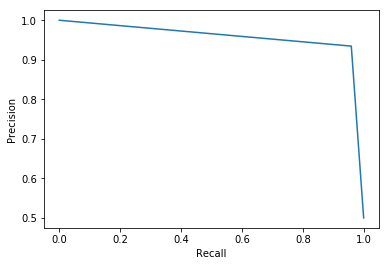

In [52]:
precision, recall, thresholds = precision_recall_curve(test_set['is_match'], predictions)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Confusion matrix, without normalization
[[39084  2814]
 [ 1702 40196]]
Normalized confusion matrix
[[0.93283689 0.06716311]
 [0.04062246 0.95937754]]


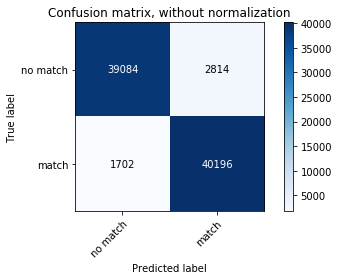

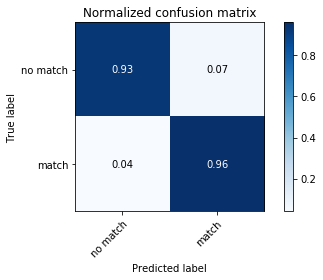

In [55]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_set['is_match'], predictions,classes=np.array(["no match", "match"]), 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_set['is_match'], predictions, classes=np.array(["no match", "match"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## save the decision trees as pictures

In [115]:
from sklearn import tree
i_tree = 0
for tree_in_forest in clf.estimators_:
    with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file, 
                                      feature_names = list(train_set.columns.difference(['is_match'])),
                class_names = ["no match", "match"],
                rounded = True, proportion = False, 
                filled = True)
    i_tree = i_tree + 1

In [124]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree_4.dot', '-o', 'tree_4.png','-Gdpi=1024'])

0

In [126]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_1.png')

## simple model

In [60]:
DEDUPE_2_ERS_DATAFIELD_MAPPING = {'legalForm':'legal_form',
                                'registerNumber':'register_number', 
                                 'address.postalCode': 'address.postal_code', 
                                 'phoneNumber': "phone_number"}
for a in D4_golden:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
for a in D4_evaluation:
    for field in DEDUPE_2_ERS_DATAFIELD_MAPPING.keys():
        a[DEDUPE_2_ERS_DATAFIELD_MAPPING[field]] = a.pop(field)
for a in D4_golden:
    a = sanitize_entity(a)
for a in D4_evaluation:
    a = sanitize_entity(a)

In [77]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)[0][1]
    
def get_vectors(*strs):
    text = [t for t in strs]
    text = ['' if v is None else str(v) for v in text]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

    

def cal_similarity(company_gold, company_evaluation):
    name = round(get_cosine_sim(company_gold['name'], company_evaluation['name']), 2)

    if company_gold['address.street'] is None or company_evaluation['address.street'] is None:
        street=0
    else:
        street = round(get_cosine_sim(company_gold['address.street'], company_evaluation['address.street']), 2)
    
    if company_gold['address.city'] is None or company_evaluation['address.city'] is None:
        city=0
    else:
        city = round(get_cosine_sim(company_gold['address.city'], company_evaluation['address.city']), 2) 
        
    if street==0 and city==0:
        return name
    elif street==0 and city!=0:
        return (3*name+2*city)/5
    elif street!=0 and city==0:
        return (3*name+2*street)/5
    else:
        return (3*name+2*street+2*city)/7




In [78]:
match_test

[[{'name': 'versorgungswerk handwerks nordrheinwestfalen ev',
   'legal_form': 'e.V.',
   'register_number': '18015',
   'email': None,
   'website': None,
   'phone_number': None,
   'vat_id': None,
   'address.street': '',
   'address.postal_code': '50667',
   'address.city': 'Köln',
   'address.country': 'Deutschland',
   'record_id': '01f0a8e0-d3e8-11e4-b3ef-53b449010d08'},
  {'name': 'versorgungswerk handwerks nordrheinwestfalen ev',
   'legal_form': 'e.V.',
   'register_number': None,
   'email': '',
   'website': '',
   'phone_number': '',
   'vat_id': None,
   'address.street': '',
   'address.postal_code': '',
   'address.city': 'Köln',
   'address.country': 'DE',
   'record_id': '01f0a8e0-d3e8-11e4-b3ef-53b449010d08'}],
 [{'name': 'edv  branchenlösung gmbh',
   'legal_form': 'GmbH',
   'register_number': '6299',
   'email': None,
   'website': None,
   'phone_number': '02941/286830',
   'vat_id': None,
   'address.street': 'bremer str 12',
   'address.postal_code': '59557',
 

In [81]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
threshold=0.8
for pair in match_test:
    try:
        similarity = cal_similarity(pair[0], pair[1])
        if similarity>threshold:
            true_positive+=1
        else:
            false_negative+=1
    except Exception:
        pass      
for pair in distinct_test:
    try:
        similarity = cal_similarity(pair[0], pair[1])
        if similarity<threshold:
            true_negative+=1
        else:
            false_positive+=1
    except Exception:
        pass      
    

In [82]:
confusion_matrix = pd.DataFrame([[true_positive, false_positive],
                                 [false_negative, true_negative]],
                                columns=['was_a_match', 'was_no_match'],
                                index=['found_a_match', 'found_no_match'])
confusion_matrix

was_a_match  was_no_match
found_a_match          6298          2998
found_no_match          427          8494

In [83]:
print('precision')
print(round(float(true_positive/(true_positive+false_positive)),2))

print('recall')
print(round(float(true_positive/(true_positive+false_negative)),2))
      
print('accuracy')
print(round(float(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative), 2))

precision
0.68
recall
0.94
accuracy
0.81
